# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the terminal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="assets/pic1.png"/>

Then you will want to run the above command:

<img src="assets/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Data Exploration

In [1]:
!python -m pip install black isort scikit-learn

In [2]:
import sys
sys.version

'3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:53:15) [MSC v.1916 64 bit (AMD64)]'

In [3]:
%load_ext autoreload

import pathlib
import pandas as pd
import numpy as np
# import math
# import json

from IPython.display import display

%matplotlib inline

# read in the json files
data_dir = pathlib.Path('data')
files = {stem: data_dir / f"{stem}.json" 
         for stem in ('portfolio','profile', 'transcript')}
dataframes = {key: pd.read_json(file, orient='records', lines=True)
              for key, file in files.items()}
portfolio = dataframes.get("portfolio")
profile = dataframes.get("profile")
transcript = dataframes.get("transcript")

## Data Exploration
### Review DataFrames

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Review Transcript specifics

## Data Cleaning

The following cell will write a file into a local module and be loaded to clean
the dataframes before feature engineering will be performed. This will add
values to null that were coded as another value, expand nested data types into
columns; such as lists; categorize columns where appropriate, and convert
date columns into DateTime values.

In [7]:
%autoreload 2
from capstone_tools.data_cleaners import clean

In [8]:
clean_dataframes = {key: clean(df, key) for key, df in dataframes.items()}
portfolio = clean_dataframes['portfolio']
profile = clean_dataframes['profile']
transcript = clean_dataframes['transcript']

In [9]:
print('Portfolio:')
display(portfolio.head())
print('Profile:')
display(profile.head())
print('Transcript:')
display(transcript.head())

Portfolio:


,reward,difficulty,duration_days,offer_type,id,web,email,mobile,social,bogo,discount,informational,duration_hours
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,168.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,120.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1,96.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0,168.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0,240.0


Profile:


,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


Transcript:


,person,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Data Visualization

In [10]:
%autoreload 2
from capstone_tools.enums import Event

Comparing Advertising types - there appears to be even distribution of web, email, mobile, and social types and more BOGO and discount types over informational

### Portfolio Data

Comparing offers to difficulty and reward intensities, there is not an even
distribution, but does not appear to be skewed, the log data will need to be compared to evaluate if this is true.

(<Figure size 1296x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Offer Types by Category'}, xlabel='Advertising Type', ylabel='Count'>,
        <AxesSubplot:title={'center':'Reward and Difficulty Offer Distribution'}, xlabel='Relative Intensity', ylabel='Count'>],
       dtype=object))

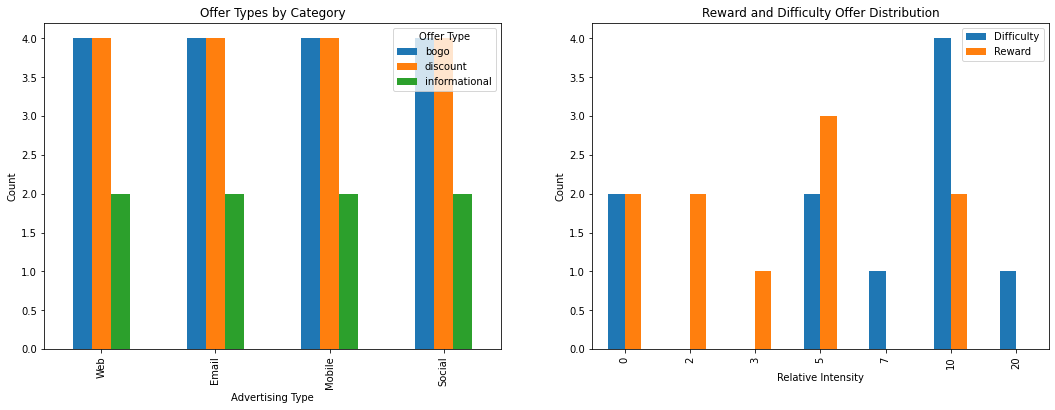

In [11]:
import matplotlib.pyplot as plt

def plot_offers_metrics_basic(portfolio: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    (
        portfolio
        .rename(columns=lambda x: x.title().replace('_', ' '))
        .groupby('Offer Type')
        .count()
        [['Web', 'Email','Mobile', 'Social']]
        .T
        .plot(
            kind='bar',
            xlabel='Advertising Type',
            ylabel='Count',
            ax=axs[0],
            title='Offer Types by Category',
        )
    )
    (
        pd.concat(objs=(
            portfolio.groupby('difficulty').count()[['reward']].rename(columns=lambda _: 'Difficulty'),
            portfolio.groupby('reward').count()[['difficulty']].rename(columns=lambda _: 'Reward')
        ), axis=1).plot(
            kind='bar',
            ax=axs[1],
            xlabel='Relative Intensity',
            ylabel='Count',
            title='Reward and Difficulty Offer Distribution')
    )
    return fig, axs

plot_offers_metrics_basic(portfolio)

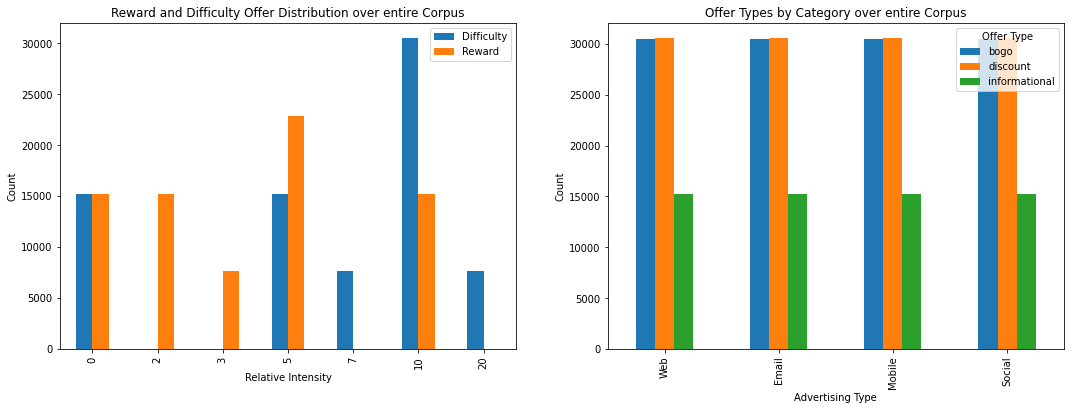

In [12]:
def plot_offers_metrics(transcript: pd.DataFrame, portfolio: pd.DataFrame):
    offers_sent = (
        pd.merge(
            transcript,
            portfolio,
            left_on='offer_id',
            right_on='id'
        )
        .query(f'event == "{Event.received}"')
    )

    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        pd.concat(objs=(
            offers_sent.groupby('difficulty').count()[['reward_y']].rename(columns=lambda _: 'Difficulty'),
            offers_sent.groupby('reward_y').count()[['difficulty']].rename(columns=lambda _: 'Reward')
        ), axis=1).plot(
            kind='bar',
            ax=axs[0],
            xlabel='Relative Intensity',
            ylabel='Count',
            title='Reward and Difficulty Offer Distribution over entire Corpus')
    )

    (
        offers_sent
        .rename(columns=lambda x: x.title().replace('_', ' '))
        .groupby('Offer Type')
        .count()
        [['Web', 'Email','Mobile', 'Social']]
        .T
        .plot(
            kind='bar',
            xlabel='Advertising Type',
            ylabel='Count',
            ax=axs[1],
            title='Offer Types by Category over entire Corpus',
        )
    );
    return fig, axs

plot_offers_metrics(transcript, portfolio);

Reviewing the entire corpus, the distribution appears to be the same.

### Profile Data

The profile data is a bit more ticky, nans exist within this dataset and some information will have to be provided as an additional category. Looking at Gender and age distributions there is a significant portion of nan values. As well as a significant skew in gender category:

In [13]:
print(f"Number of Profiles: {len(profile)}")
print(f"Number of Complete Profiles: {len(profile.dropna())}")


Number of Profiles: 17000
Number of Complete Profiles: 14825


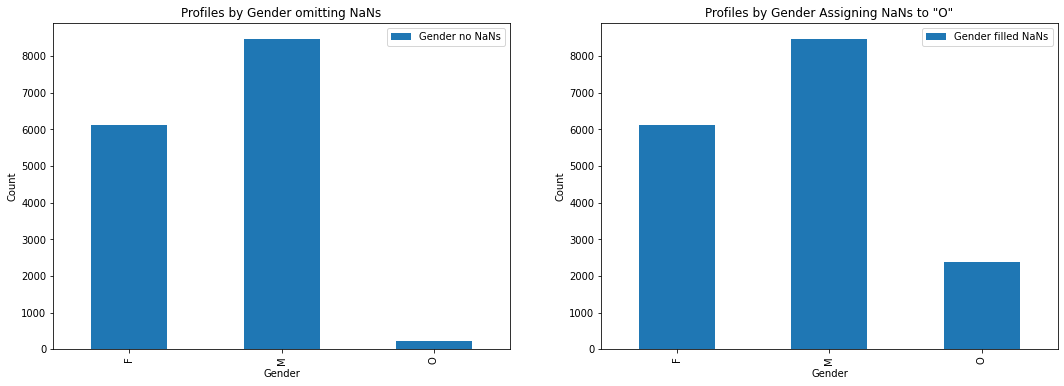

In [14]:
def plot_gender(profile: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        profile
        # .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender no NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[0],
            title='Profiles by Gender omitting NaNs',
        )
    );
    (
        profile
        .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender filled NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[1],
            title='Profiles by Gender Assigning NaNs to "O"',
        )
    )
    return fig, axs

plot_gender(profile);

There is significant skew in gender where Male is the most common followed by
female and other is a significant minor population - much lower than the profiles omitting gender all together.

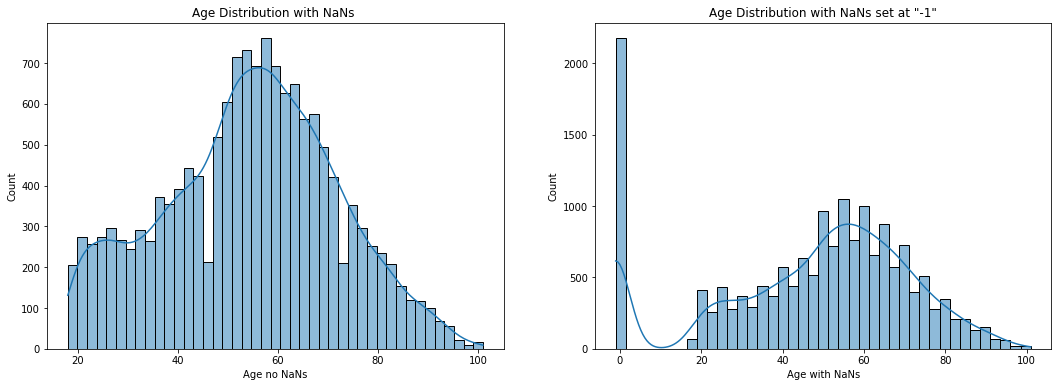

In [15]:
import seaborn as sns


def plot_age(profile):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    age_profile_no_nans = (
        profile
        # .assign(gender=lambda df: df['age'].fillna(99))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age no NaNs')
        .dropna()
    )
    age_profile_with_nan = (
        profile
        .assign(age=lambda df: df['age'].fillna(-1))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age with NaNs')
    )
    splots = []
    splots.append(sns.histplot(
        data=age_profile_no_nans,
        x = 'Age no NaNs',
        kde=True,
        ax=axs[0]
    ))
    splots.append(sns.histplot(
        data=age_profile_with_nan,
        x = 'Age with NaNs',
        kde=True,
        ax=axs[1],
    ))
    splots[0].set_title('Age Distribution with NaNs ')
    splots[1].set_title('Age Distribution with NaNs set at "-1"')
    return splots

plot_age(profile);

Moreover - there appears to be use skewwedness with income and membership
length for income, age, and gender:

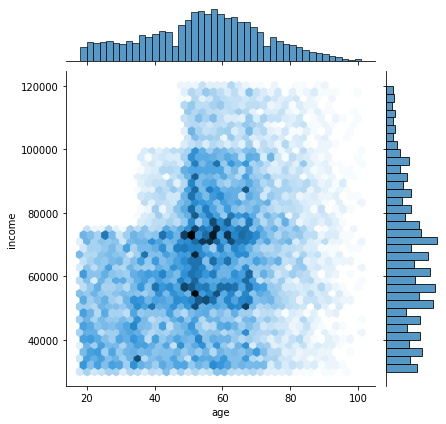

In [16]:
sns.jointplot(data=profile, x='age', y='income', kind='hex')

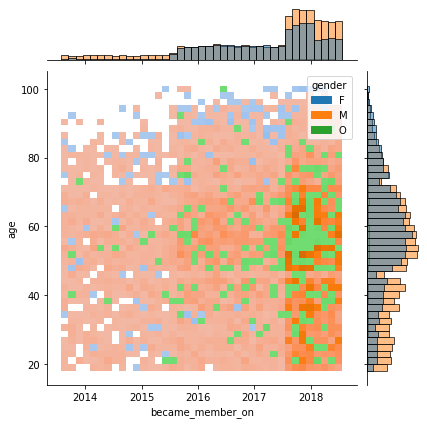

In [17]:
sns.jointplot(data = profile, x='became_member_on', y='age', kind='hist', hue='gender')

There appears to be significantly more newer members that select the non-binary gender and there appears to be much more members added between 2015 and 2016

## Feature Generation

In [18]:
%autoreload 2
from capstone_tools.feature_generation import transform

In [19]:
def get_offer_id_enum(portfolio):
    """Get offer ID enumerations - Note: save for later"""
    return portfolio['id'].reset_index().set_index('id')['index'].to_dict()


def get_enum_2_offer_id(offerid2enum):
    """Get enumerations key to offer ID"""
    return {val: key for key, val in offerid2enum.items()}


def transform_best_offer_by_person(event_df, offerid2enum):
    """Calculate the best offer per person"""
    df = event_df.groupby(['person', 'offer_id']).sum()['profit']
    max_offers = df.unstack('offer_id').fillna(0.0).idxmax(axis=1)
    max_offers.name = 'best_offer'
    return max_offers.apply(lambda x: offerid2enum.get(x))


def merge_to_final_profile(profile, best_offers):
    """Merge best offers to profile"""
    return pd.merge(
        profile, 
        best_offers, 
        how='left', 
        left_on='person', 
        right_index=True
    )

transformed_dfs = {}

key = 'transcript'
transformed_dfs[key] = transform(
    df=clean_dataframes[key],
    key=key,
    portfolio=clean_dataframes['portfolio'],
)

key = 'event'
transformed_dfs[key] = transform(
    df=transformed_dfs.get('transcript'),
    key=key,
)

key = 'profile'
transformed_dfs[key] = transform(
    df=clean_dataframes[key],
    key=key,
)

offerid2enum = get_offer_id_enum(clean_dataframes['portfolio'])
best_offers = transform_best_offer_by_person(
    transformed_dfs['transcript'], offerid2enum
)
model_data = merge_to_final_profile(transformed_dfs['profile'], best_offers)



In [20]:
print("Model Data - Profile Merged with best offers:")
display(model_data)


Model Data - Profile Merged with best offers:


,age,person,income,gender_f,gender_m,gender_o,gender_nan,membership,best_offer
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,1,2599,6
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,2752,2
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,1,3114,7
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,2685,7
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,1,2772,4
...,...,...,...,...,...,...,...,...,...
16995,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1,0,0,0,3076,9
16996,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,0,1,0,0,3115,7
16997,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,0,1,0,0,2582,7
16998,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,1,0,0,0,2257,3


**TODO: explain feature generation**

## Final Data Preprocessing 
### Standard Scaling

Nans still exist within the data and will need to be handled. This will be done
by imputing the median value of the column using SimpleImputer.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [30]:
from capstone_tools.enums import ModelDataCols as DCols

def get_labels(model_data):
    """Get label columns from model_data"""
    return model_data[[DCols.person, DCols.best_offer]]

def get_data(model_data):
    """Get data columns from model_data"""
    return model_data.drop([DCols.person, DCols.best_offer], axis=1)

def make_pipeline():
    return Pipeline([ 
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

In [42]:
labels = get_labels(model_data)
data = get_data(model_data)
data

,age,income,gender_f,gender_m,gender_o,gender_nan,membership
0,NaN,NaN,0,0,0,1,2599
1,55.0,112000.0,1,0,0,0,2752
2,NaN,NaN,0,0,0,1,3114
3,75.0,100000.0,1,0,0,0,2685
4,NaN,NaN,0,0,0,1,2772
...,...,...,...,...,...,...,...
16995,45.0,54000.0,1,0,0,0,3076
16996,61.0,72000.0,0,1,0,0,3115
16997,49.0,73000.0,0,1,0,0,2582
16998,83.0,50000.0,1,0,0,0,2257


In [47]:
def scale_data(data):
    preprocessor = make_pipeline()
    data_scaled = preprocessor.fit_transform(data)
    return pd.DataFrame(
        data=data_scaled, columns=data.columns, index=data.index
    )

data_scaled = scale_data(data)
display(data_scaled)

,age,income,gender_f,gender_m,gender_o,gender_nan,membership
0,0.032578,-0.060733,-0.750862,-0.998119,-0.112375,2.610765,-0.028088
1,0.032578,2.318549,1.331803,-0.998119,-0.112375,-0.383030,0.343983
2,0.032578,-0.060733,-0.750862,-0.998119,-0.112375,2.610765,1.224308
3,1.264535,1.723728,1.331803,-0.998119,-0.112375,-0.383030,0.181050
4,0.032578,-0.060733,-0.750862,-0.998119,-0.112375,2.610765,0.392620
...,...,...,...,...,...,...,...
16995,-0.583401,-0.556417,1.331803,-0.998119,-0.112375,-0.383030,1.131898
16996,0.402165,0.335814,-0.750862,1.001884,-0.112375,-0.383030,1.226740
16997,-0.337009,0.385382,-0.750862,1.001884,-0.112375,-0.383030,-0.069429
16998,1.757318,-0.754690,1.331803,-0.998119,-0.112375,-0.383030,-0.859776


In [ ]:
import sns
sns.pairplot(data_scaled)

### Train, Test, Validation Sets

In [46]:
import pickle

def write_col_names(location: pathlib.Path, data: pd.DataFrame):
    """Write column names to location"""
    file = location.joinpath('col_names.pkl')
    with open(file, 'wb') as fh:
        pickle.dump(data.columns, fh)

root = pathlib.Path('data/processed')
root.mkdir(exist_ok=True, parents=True)
write_col_names(root, data)

In [54]:
import pathlib
from dataclasses import dataclass
import pickle
import numpy as np

from capstone_tools.data_splitting import PreSplitData, process_scaled_data

val_splits = 0.2
test_splits = 0.2
data_cargo = PreSplitData(data_scaled, labels, test_splits, val_splits)
root = pathlib.Path('.')
location = root / "data/processed"

process_scaled_data(data_cargo, location)


## PCA


*Can start from here if you have saved your data*

In [59]:
import pathlib
import numpy as np
import pandas as pd

from capstone_tools.data_loaders import load_dataset

root = pathlib.Path('data/processed')
train_loc = root.joinpath('train')
train_data, train_labels = load_dataset(train_loc)

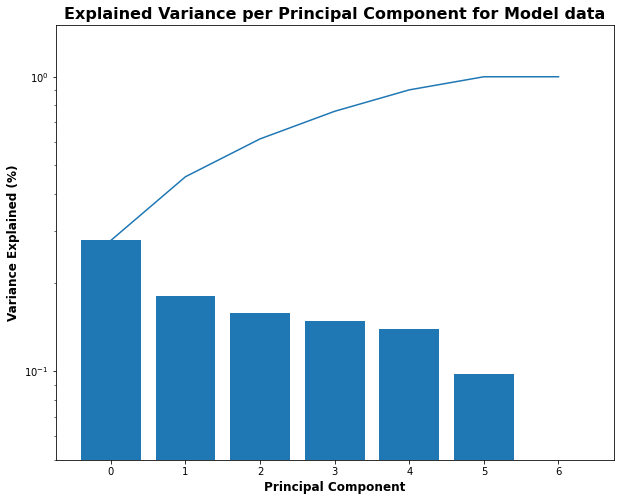

In [65]:
from sklearn.decomposition import PCA

pcas = (PCA() for _ in range(1))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dataset = (train_data,)
names = ("Model",)
axs = (ax,)
for ax, pca, data, name in zip(axs, pcas, dataset, names):
    results = pca.fit_transform(data)
    vars = pca.explained_variance_ratio_
    n = len(vars)
    ax.bar(range(n), vars)
    ax.plot(range(n), vars.cumsum())
    ax.set_ylabel("Variance Explained (%)", fontweight='bold',fontsize=12)
    ax.set_xlabel(
        f"Principal Component",
        fontweight='bold',
        fontsize=12,
    )
    ax.semilogy()
    ax.set_ylim([0.05, 1.5])
    ax.set_title(
        f"Explained Variance per Principal Component for {name.title()} data",
        fontweight='bold',
        fontsize=16,
    )

plt.show()

The PCA suggests there may be some reduction in components from 6 to 5, but this reduction is not significant such as reducing an order of magnitude, therefore PCA will not be utilized.

## Model Predictions - Unsupervised Learning

The following segment investigates if the profiles follow similar behaviors 
and if they can be classified into clusters.

In [66]:
import pathlib

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

from capstone_tools.data_loaders import load_dataset

In [76]:
root = pathlib.Path('data/processed')

train_loc = root.joinpath('train')
train_data, _ = load_dataset(train_loc)
train_data = train_data.values

In [77]:
mean_dist = []
total_clusters = 30
for n in range(1, total_clusters):
    clf = KMeans(n_clusters=n)
    clf.fit(train_data)
    d = np.sqrt(-clf.score(train_data))
    mean_dist.append(d)


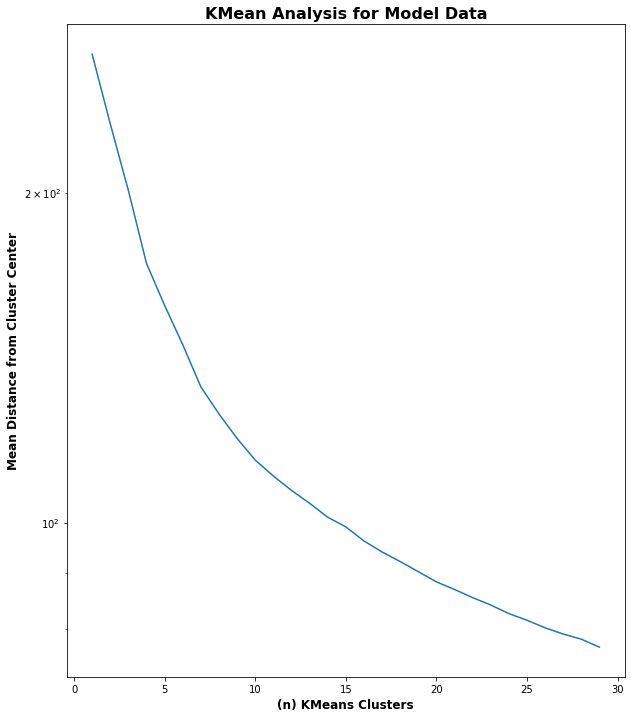

In [84]:
fix, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.plot(range(1, total_clusters), mean_dist)
# ax.semilogy()
ax.set_ylabel(
    "Mean Distance from Cluster Center",
    fontweight='bold',
    fontsize=12
)
ax.set_xlabel(
    "(n) KMeans Clusters",
    fontweight='bold',
    fontsize=12,
)
ax.semilogy()
# ax.set_ylim([0.05, 1.5])
ax.set_title(
    "KMean Analysis for Model Data",
    fontweight='bold',
    fontsize=16,
)
plt.show()

There seems to be a two sections where KMeans clustering can be utilized. There
seems to be deviations from the mean distance scores at 4 and 8 clusters. Moving forward, if unsupervised learning is applied, election of either 4 or 8
clusters will be used for the final model.

## Recommendation Model

### Baseline Model

In [1]:
%load_ext autoreload

In [29]:
%autoreload 2

import pathlib

import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from capstone_tools.data_loaders import load_data_corpus
from capstone_tools.model_trainers import SKLearnModelTrainer


data_loc = pathlib.Path("data/processed")
datasets = load_data_corpus(data_loc)

save_loc = pathlib.Path('models')

In [30]:

baseline_clfs = [
    (DummyClassifier, {}),
    (GaussianNB, {}),
    (RandomForestClassifier, {"n_estimators": 100}),
    (GradientBoostingClassifier, {"n_estimators": 100, "learning_rate": 0.1}),
    (AdaBoostClassifier, {"n_estimators": 100, "learning_rate": 0.1}),
    (DecisionTreeClassifier, {"max_depth": 5, "min_samples_split": 5}),
    (LogisticRegression, {"C": 1}),
]
for Clf, kwargs in baseline_clfs:
    acc_scores = {}
    datasets = load_data_corpus(data_loc)
    clf = Clf(**kwargs)
    clf_name = clf.__class__.__name__
    model_file = save_loc.joinpath(f"{clf_name.lower()}-model.pkl")
    trainer = SKLearnModelTrainer(clf)
    scores = trainer.train(datasets, save_path=model_file)
    acc_scores[clf_name] = trainer.train(datasets)
    acc_file = save_loc.joinpath(f"{clf_name.lower()}-scores.pkl")
    with open(acc_file, 'wb') as fh:
        pickle.dump(acc_scores, fh)
    print(
        f"{clf!r}: trained with training accuracy: "
        f"{scores['train']*100:.2f}%"
        f"  test accuracy: {scores['test']*100:.2f}%")



    

DummyClassifier(): trained with training accuracy: 14.67%  test accuracy: 14.94%
GaussianNB(): trained with training accuracy: 14.33%  test accuracy: 14.65%
RandomForestClassifier(): trained with training accuracy: 95.26%  test accuracy: 11.82%
GradientBoostingClassifier(): trained with training accuracy: 27.00%  test accuracy: 15.12%
AdaBoostClassifier(learning_rate=0.1, n_estimators=100): trained with training accuracy: 16.03%  test accuracy: 15.15%
DecisionTreeClassifier(max_depth=5, min_samples_split=5): trained with training accuracy: 16.61%  test accuracy: 14.62%
LogisticRegression(C=1): trained with training accuracy: 15.71%  test accuracy: 15.15%


### Advanced Model

In [1]:
%load_ext autoreload

In [10]:
%autoreload 2
import pathlib

import pickle
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from capstone_tools.model import RecommendationModel, ModelDimensions
from capstone_tools.model_trainers import TorchTrainer, TorchModelData
from capstone_tools.data_loaders import load_data_corpus


data_loc = pathlib.Path("data/processed")
datasets = load_data_corpus(data_loc)

In [11]:
_, input_dim = datasets['train'].X.shape
output_dim = len(set(datasets['train'].y))

In [14]:
dims = ModelDimensions(
    input_size=input_dim,
    hidden_layers=(256, 256, 256), 
    output_size=output_dim
)
clf = RecommendationModel(
    dims,
    has_dropout=True,
    p_drop=0.2,
    has_batch_norm=True,
)

In [15]:
clf


RecommendationModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [18]:
optimizer = Adam(clf.parameters(), lr=0.01)
critereon = CrossEntropyLoss()
model_data = TorchModelData(
    model=clf, optimizer=optimizer, critereon=critereon
)
trainer = TorchTrainer(model_data)
model_loc = pathlib.Path('models/nn-rec-model.pth')
losses_loc = pathlib.Path('models/nn-rec-losses.pkl')
model_loc.parent.mkdir(parents=True, exist_ok=True)

In [19]:
epochs = 100
losses = trainer.train(datasets, n_epochs=epochs, batch_size=64, save_path=model_loc)
with open(losses_loc, 'wb') as fh:
    pickle.dump(losses, fh)

Epoch: 1	Training Loss:2.2841	Valid Loss:2.2813
Validation Loss decreased(inf -> 2.2813) Saving Model...
Epoch: 3	Training Loss:2.2764	Valid Loss:2.2812
Validation Loss decreased(2.2813 -> 2.2812) Saving Model...
Epoch: 4	Training Loss:2.2763	Valid Loss:2.2811
Validation Loss decreased(2.2812 -> 2.2811) Saving Model...
Epoch: 6	Training Loss:2.2760	Valid Loss:2.2802
Validation Loss decreased(2.2811 -> 2.2802) Saving Model...
Epoch: 8	Training Loss:2.2763	Valid Loss:2.2789
Validation Loss decreased(2.2802 -> 2.2789) Saving Model...
Epoch: 16	Training Loss:2.2765	Valid Loss:2.2782
Validation Loss decreased(2.2789 -> 2.2782) Saving Model...
Epoch: 72	Training Loss:2.2761	Valid Loss:2.2781
Validation Loss decreased(2.2782 -> 2.2781) Saving Model...


In [20]:
trainer.eval(datasets['test'], batch_size=64)

Test Loss: 2.2741	Accuracy: 14.94 (508/3400)


<AxesSubplot:title={'center':'Loss over Time of FC Neural Network'}, xlabel='Epoch', ylabel='Loss'>

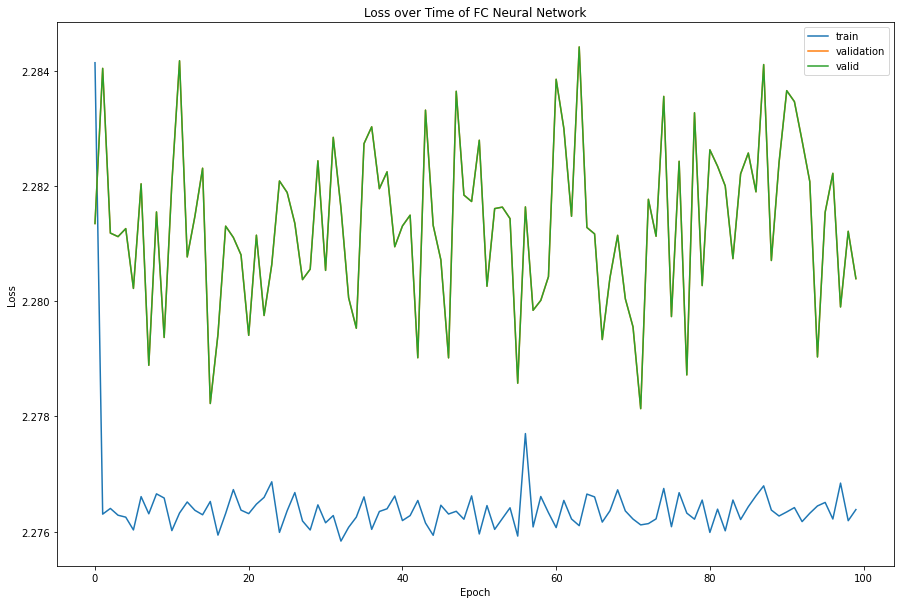

In [42]:
import pandas as pd

pd.DataFrame(losses).plot(
    figsize=(15, 10), xlabel='Epoch', ylabel='Loss', 
    title='Loss over Epoch of FC Neural Network'
)


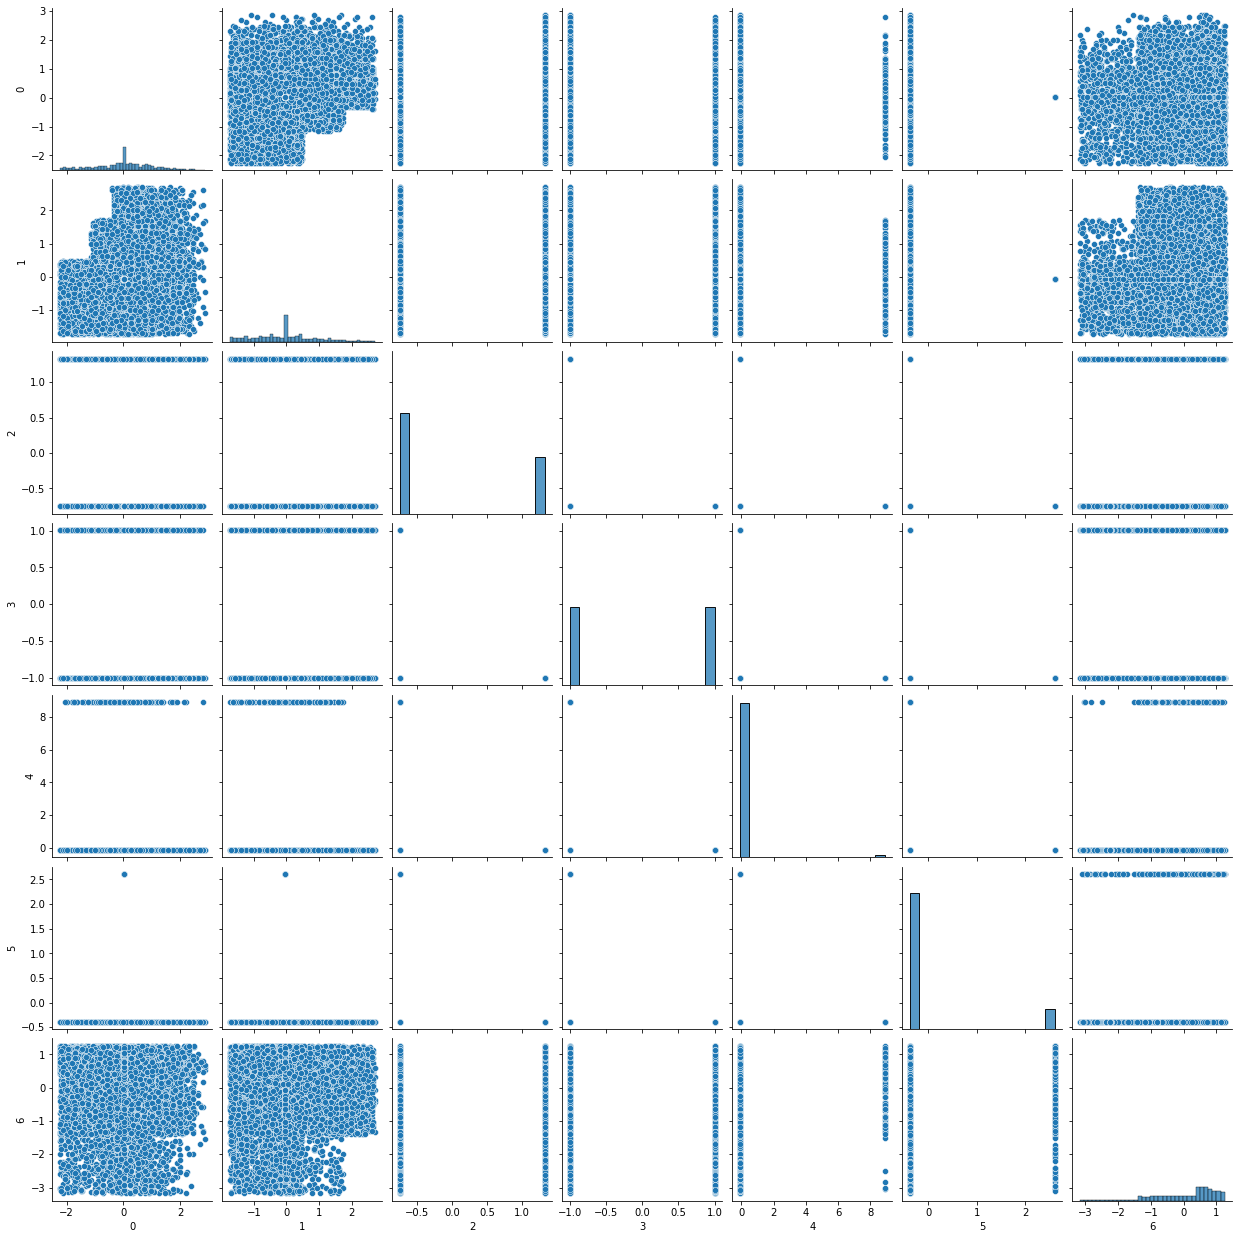

In [41]:
import seaborn as sns


sns.pairplot(pd.DataFrame(datasets['train'].X))